In [1]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from utils_segmentation import p3

np.random.seed(42)
import pickle
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
inputs = ['Rg', 'Tair', 'rH', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [3]:
daily_flux_cook=pd.read_csv('../../work/CookIRCamET/Working/cookhy2023_batches_processed.csv')
#daily_flux_cook_24=pd.read_csv('../../work/CookIRCamET/Working/cookhy2024_batches_processed.csv')
daily_flux_cprl=pd.read_csv('../../work/CookIRCamET/Working/cprlhy2023_batches_processed.csv')
#daily_flux_cook=pd.concat([daily_flux_cook_23,daily_flux_cook_24])

In [4]:
daily_flux = pd.concat([daily_flux_cook,daily_flux_cprl])

Fitting 10 folds for each of 64 candidates, totalling 640 fits


/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is de

[CV 2/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 7, 2, 1);, score=0.759 total time=   4.9s
[CV 1/10] END clf__activation=tanh, clf__hidden_layer_sizes=(7, 1, 1, 0);, score=nan total time=   0.0s
[CV 2/10] END clf__activation=tanh, clf__hidden_layer_sizes=(7, 1, 1, 0);, score=nan total time=   0.0s
[CV 4/10] END clf__activation=tanh, clf__hidden_layer_sizes=(7, 1, 1, 0);, score=nan total time=   0.0s
[CV 6/10] END clf__activation=tanh, clf__hidden_layer_sizes=(7, 1, 1, 0);, score=nan total time=   0.0s
[CV 7/10] END clf__activation=tanh, clf__hidden_layer_sizes=(7, 1, 1, 0);, score=nan total time=   0.0s
[CV 9/10] END clf__activation=tanh, clf__hidden_layer_sizes=(7, 1, 1, 0);, score=nan total time=   0.0s
[CV 1/10] END clf__activation=tanh, clf__hidden_layer_sizes=(7, 1, 1, 0);, score=nan total time=   0.0s
[CV 4/10] END clf__activation=tanh, clf__hidden_layer_sizes=(7, 1, 1, 0);, score=nan total time=   0.0s
[CV 5/10] END clf__activation=tanh, clf__hidden_layer_sizes=(

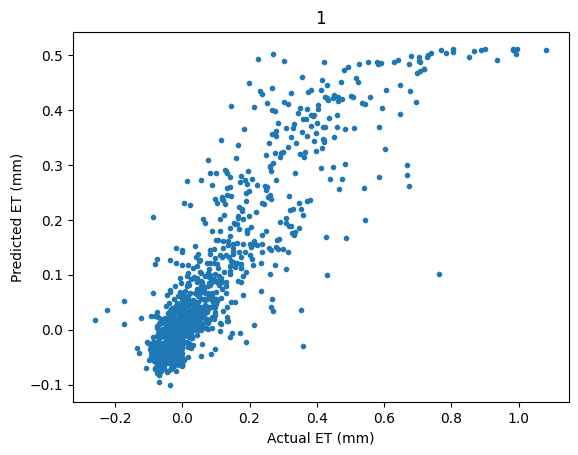

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV 7/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 7, 2, 1);, score=0.807 total time=   1.8s
[CV 1/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 3, 1, 0);, score=nan total time=   0.0s
[CV 2/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 3, 1, 0);, score=nan total time=   0.0s
[CV 3/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 3, 1, 0);, score=nan total time=   0.0s
[CV 4/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 3, 1, 0);, score=nan total time=   0.0s
[CV 5/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 3, 1, 0);, score=nan total time=   0.0s
[CV 6/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 3, 1, 0);, score=nan total time=   0.0s
[CV 7/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 3, 1, 0);, score=nan total time=   0.0s
[CV 8/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 3, 1, 0);, score=nan total tim

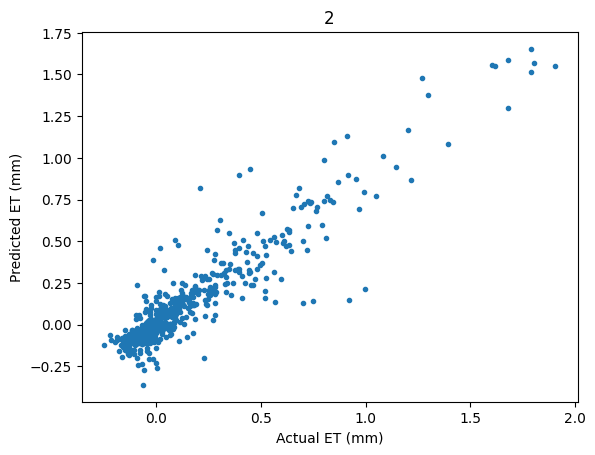

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV 8/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 7, 2, 1);, score=0.800 total time=   2.0s
[CV 2/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 2, 1, 0);, score=nan total time=   0.0s
[CV 4/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 2, 1, 0);, score=nan total time=   0.0s
[CV 6/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 2, 1, 0);, score=nan total time=   0.0s
[CV 8/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 2, 1, 0);, score=nan total time=   0.0s
[CV 10/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 2, 1, 0);, score=nan total time=   0.0s
[CV 2/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 1, 1, 0);, score=nan total time=   0.0s
[CV 4/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 1, 1, 0);, score=nan total time=   0.0s
[CV 6/10] END clf__activation=tanh, clf__hidden_layer_sizes=(21, 1, 1, 0);, score=nan total ti

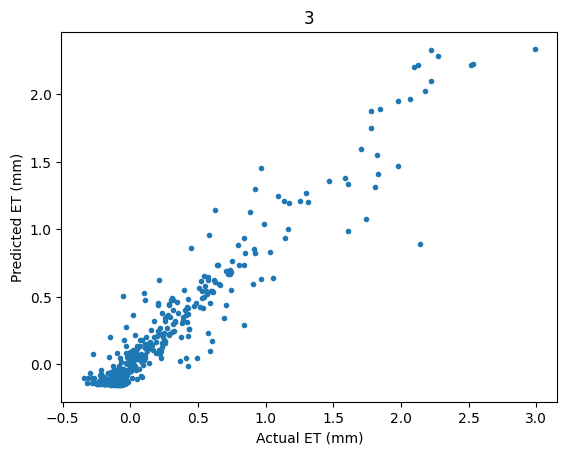

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV 9/10] END clf__activation=logistic, clf__hidden_layer_sizes=(14, 1, 1, 0);, score=nan total time=   0.0s
[CV 10/10] END clf__activation=logistic, clf__hidden_layer_sizes=(14, 1, 1, 0);, score=nan total time=   0.0s
[CV 1/10] END clf__activation=logistic, clf__hidden_layer_sizes=(14, 0, 0, 0);, score=nan total time=   0.0s
[CV 2/10] END clf__activation=logistic, clf__hidden_layer_sizes=(14, 0, 0, 0);, score=nan total time=   0.0s
[CV 3/10] END clf__activation=logistic, clf__hidden_layer_sizes=(14, 0, 0, 0);, score=nan total time=   0.0s
[CV 4/10] END clf__activation=logistic, clf__hidden_layer_sizes=(14, 0, 0, 0);, score=nan total time=   0.0s
[CV 5/10] END clf__activation=logistic, clf__hidden_layer_sizes=(14, 0, 0, 0);, score=nan total time=   0.0s
[CV 6/10] END clf__activation=logistic, clf__hidden_layer_sizes=(14, 0, 0, 0);, score=nan total time=   0.0s
[CV 7/10] END clf__activation=logistic, clf__hidden_layer_sizes=

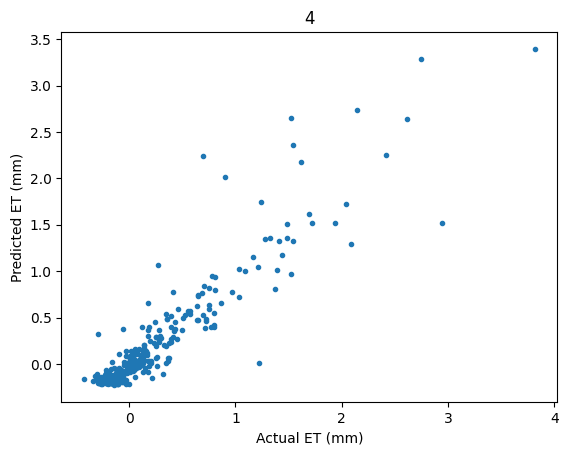

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV 4/10] END clf__activation=linear, clf__hidden_layer_sizes=(3, 1, 1, 1);, score=nan total time=   0.0s
[CV 9/10] END clf__activation=linear, clf__hidden_layer_sizes=(3, 1, 1, 1);, score=nan total time=   0.0s
[CV 4/10] END clf__activation=linear, clf__hidden_layer_sizes=(3, 0, 0, 0);, score=nan total time=   0.0s
[CV 7/10] END clf__activation=linear, clf__hidden_layer_sizes=(3, 0, 0, 0);, score=nan total time=   0.0s
[CV 1/10] END clf__activation=linear, clf__hidden_layer_sizes=(3, 0, 0, 0);, score=nan total time=   0.0s
[CV 6/10] END clf__activation=linear, clf__hidden_layer_sizes=(3, 0, 0, 0);, score=nan total time=   0.0s
[CV 1/10] END clf__activation=tanh, clf__hidden_layer_sizes=(84, 19, 4, 4);, score=0.911 total time=   2.6s
[CV 9/10] END clf__activation=tanh, clf__hidden_layer_sizes=(84, 19, 4, 4);, score=0.821 total time=   2.7s
[CV 7/10] END clf__activation=tanh, clf__hidden_layer_sizes=(84, 9, 3, 1);, score=0.8

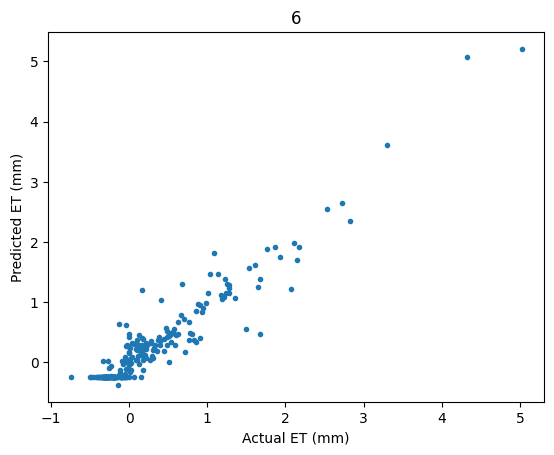

[CV 4/10] END clf__activation=linear, clf__hidden_layer_sizes=(6, 3, 1, 6);, score=nan total time=   0.0s
[CV 9/10] END clf__activation=linear, clf__hidden_layer_sizes=(6, 3, 1, 6);, score=nan total time=   0.0s
[CV 10/10] END clf__activation=linear, clf__hidden_layer_sizes=(6, 3, 1, 6);, score=nan total time=   0.0s
[CV 1/10] END clf__activation=linear, clf__hidden_layer_sizes=(6, 1, 1, 2);, score=nan total time=   0.0s
[CV 2/10] END clf__activation=linear, clf__hidden_layer_sizes=(6, 1, 1, 2);, score=nan total time=   0.0s
[CV 1/10] END clf__activation=linear, clf__hidden_layer_sizes=(6, 1, 1, 1);, score=nan total time=   0.0s
[CV 2/10] END clf__activation=linear, clf__hidden_layer_sizes=(6, 1, 1, 1);, score=nan total time=   0.0s
[CV 3/10] END clf__activation=linear, clf__hidden_layer_sizes=(6, 1, 1, 1);, score=nan total time=   0.0s
[CV 4/10] END clf__activation=linear, clf__hidden_layer_sizes=(6, 1, 1, 1);, score=nan total time=   0.0s
[CV 9/10] END clf__activation=linear, clf__hi

In [5]:
n_feats = len(inputs)
best_scores = []
for period_length in [1,2,3,4,6]:
    batched_flux = daily_flux[[*inputs]].values.reshape([-1,period_length*n_feats])
    batched_et = daily_flux[['ET']].values.reshape([-1,period_length])
    n_batches = batched_flux.shape[0]
    n_train = int(0.9*n_batches)
    n_test = n_batches-n_train
    batches = np.arange(n_batches)
    np.random.shuffle(batches)
    train = batches[0:n_train]
    test = batches[n_train:]
    batches_train_et,batches_train_feats = np.sum(batched_et[train,:],axis=1),batched_flux[train,0:period_length*n_feats] 
    batches_test_et,batches_test_feats =  np.sum(batched_et[test,:],axis=1),batched_flux[test,0:period_length*n_feats] 
    batches_train_et.shape
    
    #Pipeline
    #initial scaling
    scaler = StandardScaler()
    clf = MLPRegressor(max_iter=10000)
    #tune hyperparameters
    layers = []
    
    for layer1 in [1,3,7,21]:
        for layer2 in [1,3,6,18]:
            layer = (n_feats*period_length//layer1,int((n_feats*period_length//(layer2*layer1))**(2/3)),int((n_feats*period_length//(layer2*layer1))**(1/3)),period_length//layer2)
            layers.append(layer)
    
    parameters = {'clf__hidden_layer_sizes':layers,'clf__activation':['tanh','relu','logistic','linear']}
    pipeline = Pipeline(steps=[("scaler", scaler), ("clf", clf)])#
    
    search = GridSearchCV(pipeline, parameters,n_jobs=-1,cv=10,verbose=3)
    
    search.fit(batches_train_feats, batches_train_et)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    filename = os.path.join(p3,'et_mlp_pipeline_'+str(period_length)+'_final.pk.sav')
    with open(filename, 'wb') as f:  # Python 3: open(..., 'wb'
        pickle.dump(search.best_estimator_, f)
    pred = search.predict(batches_test_feats)
    mlp = search.best_estimator_['clf']

    n_param = 0
    for i in range(4):
        n_param+=mlp.coefs_[i].shape[0]*mlp.coefs_[i].shape[0]
    
    best_scores.append([mean_squared_error(pred,batches_test_et)/period_length,
                        r2_score(pred,batches_test_et),period_length,n_param,n_train])
    plt.plot(batches_test_et,pred,'.')
    plt.title(str(period_length))
    plt.ylabel('Predicted ET (mm)')
    plt.xlabel('Actual ET (mm)')
    plt.show()

Text(0.5, 0, 'MSE (mm2)')

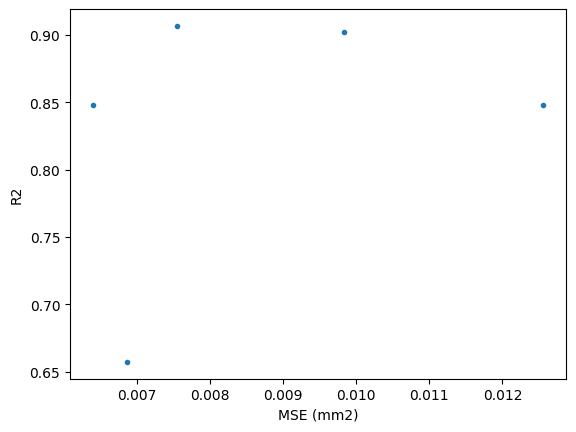

In [7]:
plt.plot(np.array(best_scores)[:,0],np.array(best_scores)[:,1],'.')
plt.ylabel('R2')
plt.xlabel('MSE (mm2)')

In [6]:
np.array(best_scores)

array([[6.86028508e-03, 6.57302746e-01, 1.00000000e+00, 9.35000000e+02,
        1.29810000e+04],
       [6.38790473e-03, 8.48173154e-01, 2.00000000e+00, 3.68100000e+03,
        6.49000000e+03],
       [7.54587391e-03, 9.06522007e-01, 3.00000000e+00, 8.17200000e+03,
        4.32700000e+03],
       [1.25622038e-02, 8.47552008e-01, 4.00000000e+00, 1.44890000e+04,
        3.24500000e+03],
       [9.83181819e-03, 9.02077735e-01, 6.00000000e+00, 3.24020000e+04,
        2.16300000e+03]])